# Aerospace Design via Quasiconvex Optimization 

Consider a triangle, or a wedge, located within a hypersonic flow. A standard aerospace design optimization problem is to design the wedge to maximize the lift-to-drag ratio (L/D) (or conversely minimize the D/L ratio), subject to certain geometric constraints. In this example, the wedge is known to have a constant hypotenuse, and our job is to choose its width and height.

The drag-to-lift ratio is given by

$$
\frac{\mathrm{D}}{\mathrm{L}} = \frac{\mathrm{c_d}}{\mathrm{c_l}},
$$

where $\mathrm{c_d}$ and $\mathrm{c_l}$ are drag and lift coefficients, respectively, that are obtained by integrating the projection of the pressure coefficient in directions parallel to, and perpendicular to, the body.

It turns out that the drag-to-lift ratio is a quasilinear function, as we'll now show. We will assume the pressure coefficient is given by the Newtonian sine-squared law for whetted areas of the body,

$$
\mathrm{c_p} = 2(\hat{v}\cdot\hat{n})^2
$$

and elsewhere $\mathrm{c_p} = 0$. Here, $\hat{v}$ is the free stream direction, which for simplicity we will assume is parallel to the body so that, $\hat{v} = \langle 1, 0 \rangle$, and $\hat{n}$ is the local unit normal. For a wedge defined by width $\Delta x$, and height $\Delta y$, 

$$
\hat{n} = \langle -\Delta y/s,-\Delta x/s \rangle
$$

where $s$ is the hypotenuse length. Therefore,

$$
\mathrm{c_p} = 2((1)(-\Delta y/s)+(0)(-\Delta x/s))^2 = \frac{2 \Delta y^2}{s^2}
$$

The lift and drag coefficients are given by

$$
\begin{align*}
\mathrm{c_d} &= \frac{1}{c}\int_0^s -\mathrm{c_p}\hat{n}_x \mathrm{d}s \\
\mathrm{c_l} &= \frac{1}{c}\int_0^s -\mathrm{c_p}\hat{n}_y \mathrm{d}s
\end{align*}
$$

Where $c$ is the reference chord length of the body. Given that $\hat{n}$, and therefore $\mathrm{c_p}$ are constant over the whetted surface of the body,

$$
\begin{align*}
\mathrm{c_d} &= -\frac{s}{c}\mathrm{c_p}\hat{n}_x = \frac{s}{c}\frac{2 \Delta y^2}{s^2}\frac{\Delta y}{s} \\
\mathrm{c_l} &= -\frac{s}{c}\mathrm{c_p}\hat{n}_y = \frac{s}{c}\frac{2 \Delta y^2}{s^2}\frac{\Delta x}{s}
\end{align*}
$$

Assuming $s=1$, so that $\Delta y = \sqrt{1-\Delta x^2}$, plugging in the above into the equation for $D/L$, we obtain 

$$
\frac{\mathrm{D}}{\mathrm{L}} = \frac{\Delta y}{\Delta x} = \frac{\sqrt{1-\Delta x^2}}{\Delta x} = \sqrt{\frac{1}{\Delta x^2}-1}.
$$

This function is representable as a DQCP, quasilinear function. We plot it below, and then we write it using DQCP.


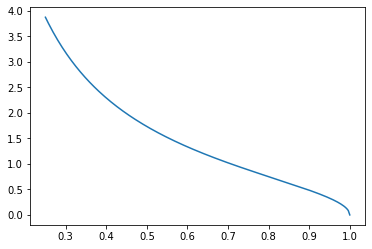

In [0]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

x = np.linspace(.25,1,num=201)
obj = []
for i in range(len(x)):
    obj.append(math.sqrt(1/x[i]**2-1))

plt.plot(x,obj)

In [0]:
import cvxpy as cp

x = cp.Variable(pos=True)
obj = cp.sqrt(cp.inv_pos(cp.square(x))-1)
print("This objective function is", obj.curvature)

This objective function is QUASILINEAR


Minimizing this objective function subject to constraints representing payload requirements is a standard aerospace design problem. In this case we will consider the constraint that the wedge must be able to contain a rectangle of given length and width internally along its hypotenuse. This is representable as a convex constraint.

In [0]:
a = .05 # USER INPUT: height of rectangle, should be at most b
b = .65 # USER INPUT: width of rectangle
constraint = [a*cp.inv_pos(x)-(1-b)*cp.sqrt(1-cp.square(x))<=0]
print(constraint)

[Inequality(Expression(CONVEX, UNKNOWN, ()))]


In [0]:
prob = cp.Problem(cp.Minimize(obj), constraint)
prob.solve(qcp=True, verbose=True)
print('Final L/D Ratio = ', 1/obj.value)
print('Final width of wedge = ', x.value)
print('Final height of wedge = ', math.sqrt(1-x.value**2))


********************************************************************************
Preparing to bisect problem

minimize 0.0
subject to 0.05 * var30766 + -0.35 * var30793 <= 0.0
           SOC(reshape(var30747 + var30766, (1,)), Vstack(reshape(var30747 + -var30766, (1, 1)), reshape(2.0 * 1.0, (1, 1))))
           SOC(reshape(var30779 + 1.0, (1,)), Vstack(reshape(var30779 + -1.0, (1, 1)), reshape(2.0 * var30747, (1, 1))))
           SOC(reshape(1.0 + -var30779 + 1.0, (1,)), Vstack(reshape(1.0 + -var30779 + -1.0, (1, 1)), reshape(2.0 * var30793, (1, 1))))
           power(power(power(param30811, 2) + --1.0, -1), 1/2) <= var30747

Finding interval for bisection ...
initial lower bound: 0.000000
initial upper bound: 1.000000

(iteration 0) lower bound: 0.000000
(iteration 0) upper bound: 1.000000
(iteration 0) query point: 0.500000 
(iteration 0) query was feasible. Solution(status=optimal, opt_val=0.0, primal_vars={30766: array(1.28425055), 30793: array(0.32048066), 30747: 0.92036983695093

Once the solution has been found, we can create a plot to verify that the rectangle is inscribed within the wedge.

(-0.04947620645689951,
 1.0390003355948896,
 -0.15158793820131744,
 0.0072184732476817896)

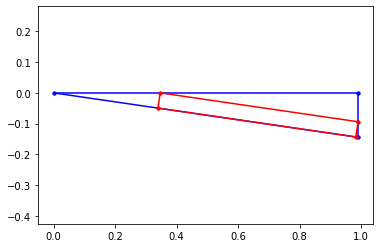

In [0]:
y = math.sqrt(1-x.value**2)
lambda1 = a*x.value/y
lambda2 = a*x.value**2/y+a*y
lambda3 = a*x.value-y*(a*x.value/y-b)

plt.plot([0,x.value],[0,0],'b.-')
plt.plot([0,x.value],[0,-y],'b.-')
plt.plot([x.value,x.value],[0,-y],'b.-')

pt1 = [lambda1*x.value,-lambda1*y]
pt2 = [(lambda1+b)*x.value,-(lambda1+b)*y]
pt3 = [(lambda1+b)*x.value+a*y,-(lambda1+b)*y+a*x.value]
pt4 = [lambda1*x.value+a*y,-lambda1*y+a*x.value]

plt.plot([pt1[0],pt2[0]],[pt1[1],pt2[1]],'r.-')
plt.plot([pt2[0],pt3[0]],[pt2[1],pt3[1]],'r.-')
plt.plot([pt3[0],pt4[0]],[pt3[1],pt4[1]],'r.-')
plt.plot([pt4[0],pt1[0]],[pt4[1],pt1[1]],'r.-')

plt.axis('equal')